# Train a RetinaNet to Detect ElectroMagnetic Signals

**Author:** [lukewood](https://lukewood.xyz), Kevin Anderson, Peter Gerstoft<br>
**Date created:** 2022/08/16<br>
**Last modified:** 2022/08/16<br>
**Description:** Train ...

## Overview

In [7]:
import sys

import keras_cv
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from absl import flags
from keras_cv import bounding_box
from tensorflow import keras
from tensorflow.keras import callbacks as callbacks_lib
from tensorflow.keras import optimizers
from luketils import artifacts
import em_loader
import wandb
from luketils import visualization

batch_size = 8
epochs = 1

class_ids = [
    "Source",
]
class_mapping = dict(zip(range(len(class_ids)), class_ids))

In [26]:
checkpoint_path = 'weights/'

In [15]:
import os
artifacts_dir = 'artifacts'
artifacts.set_base(artifacts_dir)
os.makedirs(artifacts_dir)

## Data loading

Great!  Our data is now loaded into the format
`{"images": images, "bounding_boxes": bounding_boxes}`.  This format is supported in all
KerasCV preprocessing components.

Lets load some data and verify that our data looks as we expect it to.

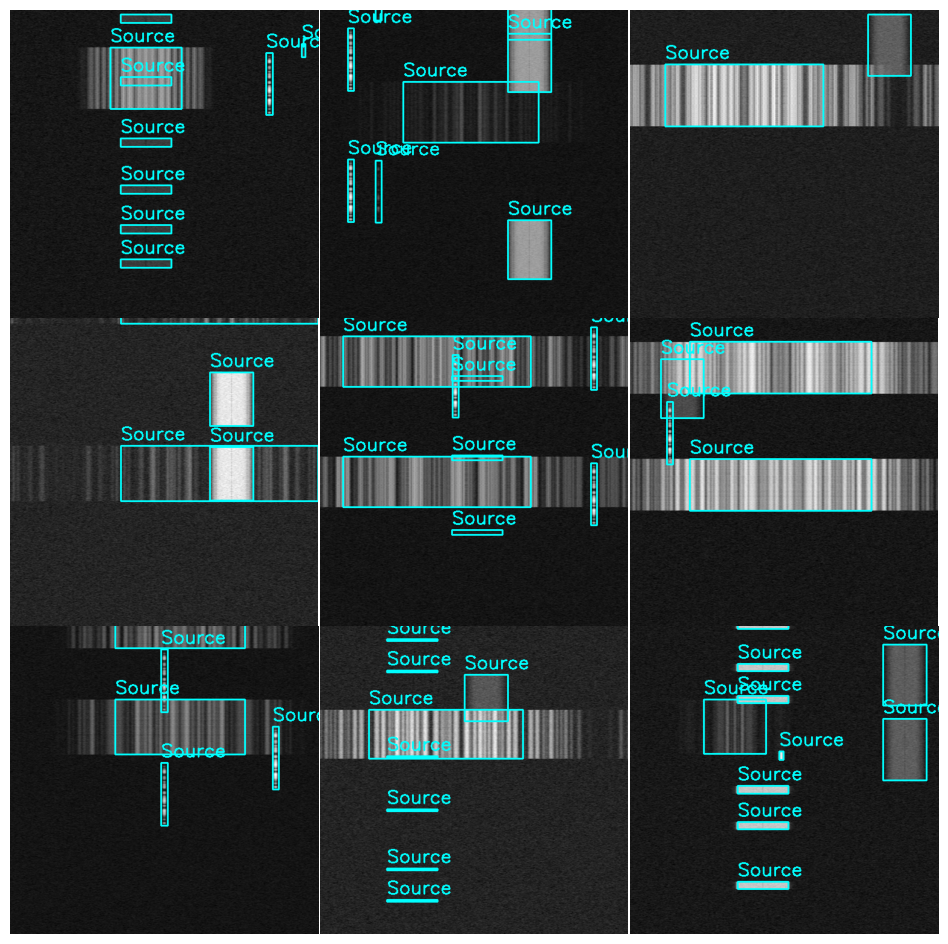

In [22]:
dataset, dataset_info = em_loader.load(
    split="train",
    bounding_box_format="xywh",
    batch_size=9,
    version=2,
)


example = next(iter(dataset))
images, boxes = example["images"], example["bounding_boxes"]
visualization.plot_bounding_box_gallery(
    images,
    value_range=(0, 255),
    bounding_box_format="xywh",
    y_true=boxes,
    scale=4,
    rows=3,
    cols=3,
    thickness=2,
    font_scale=1,
    class_mapping=class_mapping,
    path=f"{artifacts_dir}/ground-truth.png",
)
visualization.plot_bounding_box_gallery(
    images,
    value_range=(0, 255),
    bounding_box_format="xywh",
    y_true=boxes,
    scale=4,
    rows=3,
    cols=3,
    thickness=2,
    font_scale=1,
    class_mapping=class_mapping,
    show=True,
)

Looks like everything is structured as expected.  Now we can move on to constructing our
data pipeline

In [24]:
# train_ds is batched as a (images, bounding_boxes) tuple
# bounding_boxes are ragged
train_ds, train_dataset_info = em_loader.load(
    bounding_box_format="xywh", split="train", batch_size=batch_size, version=2
)
val_ds, val_dataset_info = em_loader.load(
    bounding_box_format="xywh", split="val", batch_size=batch_size, version=2
)


def unpackage_dict(inputs):
    return inputs["images"], inputs["bounding_boxes"]


train_ds = train_ds.map(unpackage_dict, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(unpackage_dict, num_parallel_calls=tf.data.AUTOTUNE)

train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

Our data pipeline is now complete.  We can now move on to model creation and training.

## Model creation

We'll use the KerasCV API to construct a RetinaNet model.  In this tutorial we use
a pretrained ResNet50 backbone using weights.  In order to perform fine-tuning, we
freeze the backbone before training.  When `include_rescaling=True` is set, inputs to
the model are expected to be in the range `[0, 255]`.

In [41]:
model = keras_cv.models.RetinaNet(
    classes=1,
    bounding_box_format="xywh",
    backbone="resnet50",
    backbone_weights="imagenet",
    include_rescaling=True,
    evaluate_train_time_metrics=False,
)

optimizer = tf.optimizers.SGD(global_clipnorm=10.0)
metrics = [
    keras_cv.metrics.COCOMeanAveragePrecision(
        class_ids=range(1),
        bounding_box_format="xywh",
        name="MaP",
    ),
    keras_cv.metrics.COCORecall(
        class_ids=range(1),
        bounding_box_format="xywh",
        max_detections=100,
        name="Recall",
    ),
]

model.compile(
    classification_loss=keras_cv.losses.FocalLoss(from_logits=True, reduction="none"),
    box_loss=keras_cv.losses.SmoothL1Loss(l1_cutoff=1.0, reduction="none"),
    optimizer=optimizer,
    metrics=metrics,
)

All that is left to do is construct some callbacks:

In [43]:
callbacks = [
    callbacks_lib.TensorBoard(log_dir="logs"),
    callbacks_lib.EarlyStopping(patience=20),
    callbacks_lib.ReduceLROnPlateau(patience=10),
    keras.callbacks.ModelCheckpoint(checkpoint_path, save_weights_only=True),
]

And run `model.fit()`!

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds.take(20),
    epochs=200,
    callbacks=callbacks,
)

Epoch 1/200
483/483 [==============================] - 75s 139ms/step - loss: 3.3700 - classification_loss: 1.3833 - regularization_loss: 0.0000e+00 - box_loss: 1.9867 - val_MaP: 0.1062 - val_Recall: 0.1511 - val_loss: 1.7703 - val_classification_loss: 0.6646 - val_box_loss: 1.1057 - val_regularization_loss: 0.0000e+00 - lr: 0.0100
Epoch 2/200
483/483 [==============================] - 64s 132ms/step - loss: 1.1656 - classification_loss: 0.3394 - regularization_loss: 0.0000e+00 - box_loss: 0.8262 - val_MaP: 0.1292 - val_Recall: 0.1863 - val_loss: 0.9767 - val_classification_loss: 0.3280 - val_box_loss: 0.6487 - val_regularization_loss: 0.0000e+00 - lr: 0.0100
Epoch 3/200
483/483 [==============================] - 63s 131ms/step - loss: 0.7360 - classification_loss: 0.1721 - regularization_loss: 0.0000e+00 - box_loss: 0.5639 - val_MaP: 0.1371 - val_Recall: 0.1880 - val_loss: 0.8833 - val_classification_loss: 0.3841 - val_box_loss: 0.4992 - val_regularization_loss: 0.0000e+00 - lr: 0.010

483/483 [==============================] - 64s 131ms/step - loss: 0.0297 - classification_loss: 4.4780e-04 - regularization_loss: 0.0000e+00 - box_loss: 0.0293 - val_MaP: 0.2066 - val_Recall: 0.2340 - val_loss: 0.4580 - val_classification_loss: 0.2424 - val_box_loss: 0.2157 - val_regularization_loss: 0.0000e+00 - lr: 0.0100
Epoch 26/200
483/483 [==============================] - 64s 132ms/step - loss: 0.0271 - classification_loss: 4.2592e-04 - regularization_loss: 0.0000e+00 - box_loss: 0.0267 - val_MaP: 0.2123 - val_Recall: 0.2390 - val_loss: 0.4824 - val_classification_loss: 0.2502 - val_box_loss: 0.2322 - val_regularization_loss: 0.0000e+00 - lr: 0.0100
Epoch 27/200
483/483 [==============================] - 64s 132ms/step - loss: 0.0261 - classification_loss: 3.6572e-04 - regularization_loss: 0.0000e+00 - box_loss: 0.0257 - val_MaP: 0.2012 - val_Recall: 0.2345 - val_loss: 0.4628 - val_classification_loss: 0.2480 - val_box_loss: 0.2148 - val_regularization_loss: 0.0000e+00 - lr: 0.0

In [ ]:
metrics = history.history

In [ ]:
metrics_to_plot = {
    'loss': metric['loss'],
    'val_loss': metric['val_loss'],
}

In [0]:
model.load_weights(checkpoint_path)

In [ ]:
metrics = model.evaluate(val_ds, return_dict=True)
print("FINAL METRICS:", metrics)

if artifacts_dir is not None:
    for metric in metrics:
        with open(f"{artifacts_dir}/metrics_{metric}.txt", "w") as f:
            f.write(metrics[metric])

In [33]:
def visualize_detections(model, split="train"):
    train_ds, val_dataset_info = em_loader.load(
        bounding_box_format="xywh", split=split, batch_size=9
    )
    train_ds = train_ds.map(unpackage_dict, num_parallel_calls=tf.data.AUTOTUNE)
    images, y_true = next(iter(train_ds.take(1)))
    y_pred = model.predict(images)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format='xywh',
        y_true=y_true,
        y_pred=y_pred,
        scale=4,
        rows=3,
        cols=3,
        thickness=2,
        font_scale=1,
        class_mapping=class_mapping,
        show=True,
    )
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format='xywh',
        y_true=y_true,
        y_pred=y_pred,
        scale=4,
        rows=3,
        cols=3,
        thickness=2,
        font_scale=1,
        class_mapping=class_mapping,
        show=False,
        path=f"{artifacts_dir}/{split}.png",
    )

1/1 [==============================] - 0s 100ms/step


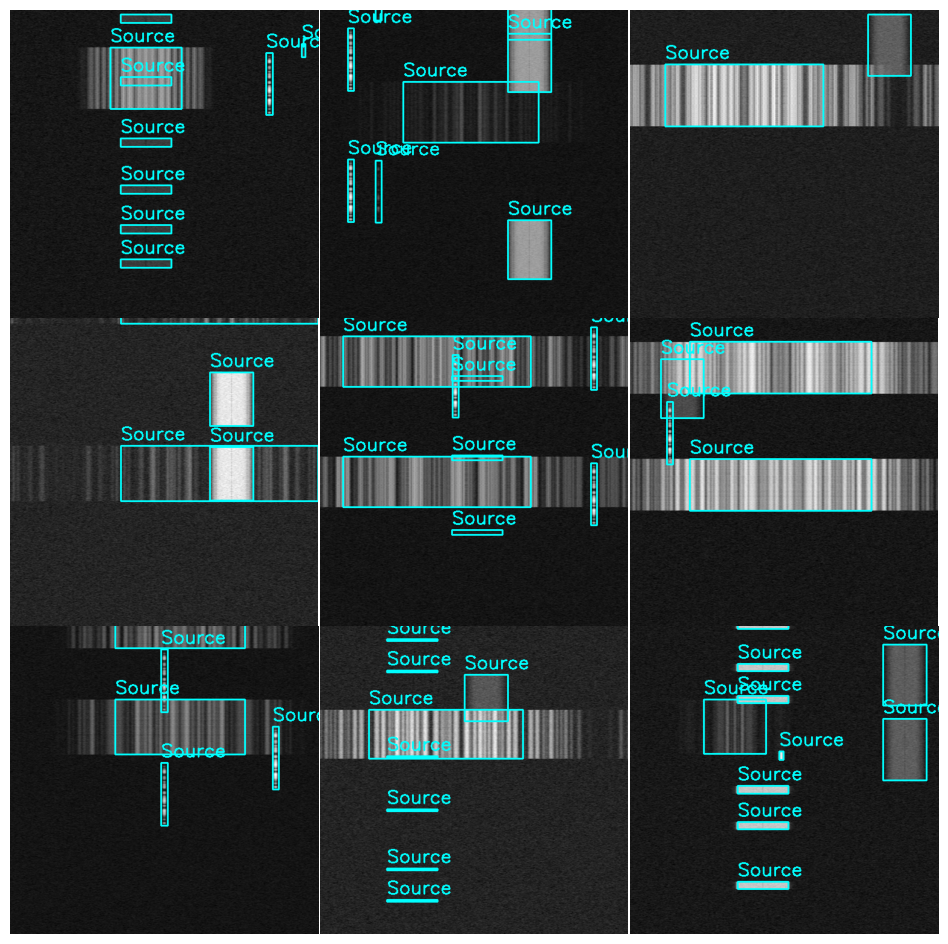

In [34]:
visualize_detections(model, split="train")

1/1 [==============================] - 0s 66ms/step


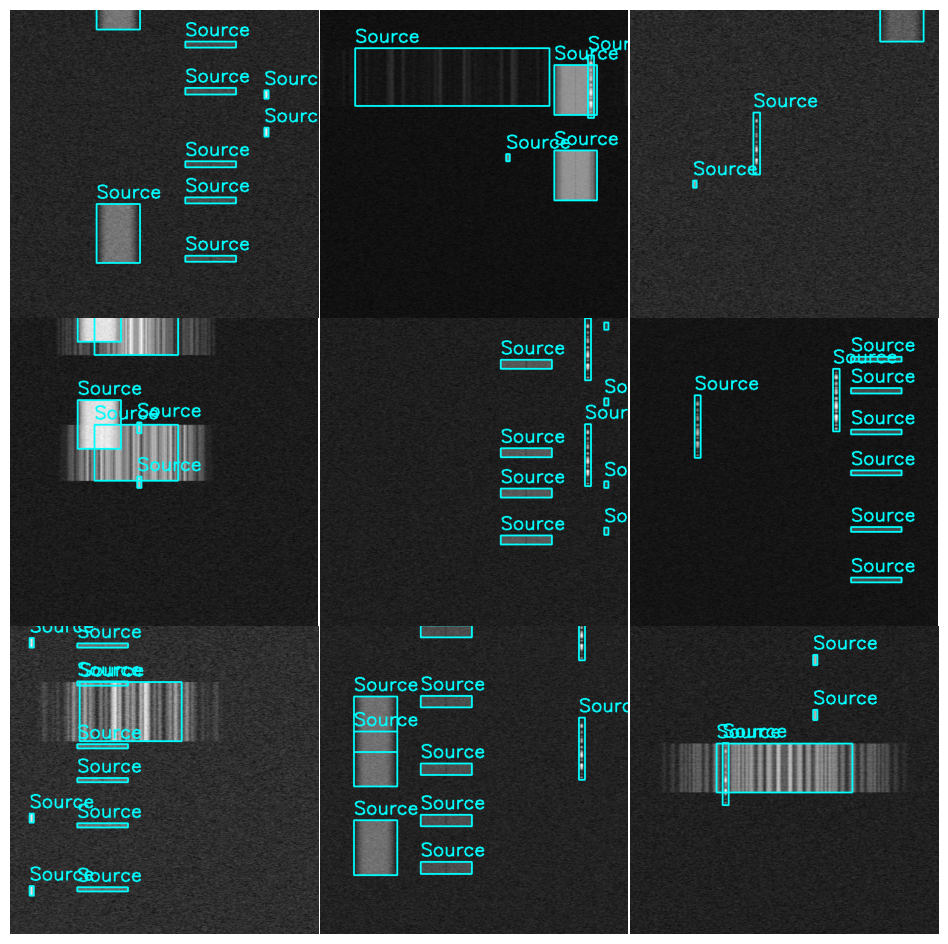

In [35]:
visualize_detections(model, split="val")